In [5]:
#Step 1: make configurations 

import numpy as np

N = 256
num_configs = 100000
thermalization = 1_000_000
separation = 1000
K = 0.7

probability_accept = np.exp(-4*K)

def update(s):

    site = np.random.randint(N)

    if s[site] == s[site - 1] and s[site] == s[(site + 1) % N]:
        if np.random.uniform() < probability_accept:
            s_new = s.copy()
            s_new[site] = -s[site]
            return s_new
        else:
            return s
    else:
        s_new = s.copy()
        s_new[site] = -s[site]
        return s_new

s = [1] * N

from tqdm import tqdm

# Thermalization
for _ in tqdm(range(thermalization), desc="Thermalizing"):
    s = update(s)

# Sampling
walk = []
for _ in tqdm(range(num_configs), desc="Sampling"):
    for _ in range(separation):
        s = update(s)
    walk.append(s.copy())

for _ in range(thermalization):
    s = update(s)

walk = []

for config in range(num_configs):
    for _ in range(separation):
        s = update(s)
    walk.append(s)

with open("configurations.dat", "w") as file:
    for config in walk:
        config_parsed = ""
        for spin in config:
            config_parsed += str(spin) + " "
        config_parsed += "\n"
        file.write(config_parsed)

In [2]:
#Step 2: calculate the correlations

import numpy as np

walk = []

with open("configurations.dat", "r") as file:
    for line in file.readlines():
        walk.append([int(spin) for spin in line.split(" ")[:-1]])

N = len(walk[0])

two_pt = []
for delta in range(N):
    averages = []
    for config in walk:
        average = 0
        for site in range(N):
            average += config[site] * config[(site + delta) % N]
        average /= N
        averages.append(average)
    two_pt.append(np.mean(averages))

with open("two_pt.dat", "w") as file:
    for delta in range(N):
        file.write(str(two_pt[delta]) + "\n")

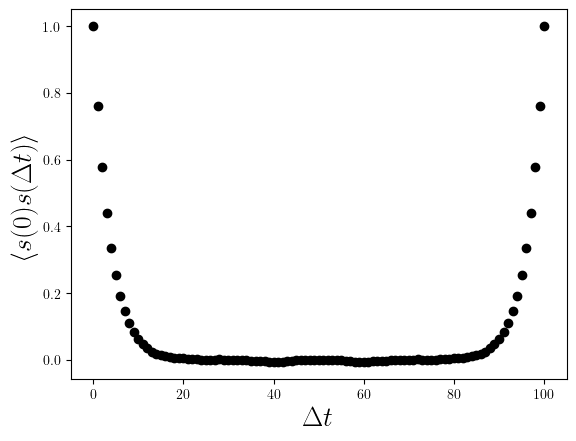

In [3]:
# Step 3: plot 2 point correlation

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{physics}"

two_pt = []
with open("two_pt.dat", "r") as file:
    for line in file.readlines():
        two_pt.append(float(line))
two_pt.append(two_pt[0])

deltas = list(range(len(two_pt)))

fig, ax = plt.subplots()
ax.scatter(deltas, two_pt, color = "k")
ax.set_xlabel(r"$\Delta t$", fontsize = 20)
ax.set_ylabel(r"$\ev{s(0)s(\Delta t)}$", fontsize = 20)
plt.show()

In [4]:
#Step 4: make error bars using jackknife method by for all separtions

import numpy as np

# Load configurations
walk = []
with open("configurations.dat", "r") as file:
    for line in file:
        walk.append([int(spin) for spin in line.split()])

walk = np.array(walk)
M, N = walk.shape  # M = number of configurations, N = number of spins

# Initialize arrays for mean and jackknife samples
two_pt = np.zeros(N)
two_pt_jk = np.zeros((M, N))

# Compute full average for each delta
for delta in range(N):
    averages = []
    for config in walk:
        avg = np.mean([config[i] * config[(i + delta) % N] for i in range(N)])
        averages.append(avg)
    two_pt[delta] = np.mean(averages)

# Compute jackknife samples
for tau in range(M):
    for delta in range(N):
        avg = np.mean([
            walk[tau][i] * walk[tau][(i + delta) % N]
            for i in range(N)
        ])
        # Jackknife resampled value
        two_pt_jk[tau, delta] = (M * two_pt[delta] - avg) / (M - 1)

# Compute error bars
jk_mean = np.mean(two_pt_jk, axis=0)
jk_std = np.std(two_pt_jk,axis=0)
jk_err = np.sqrt((M - 1)) * jk_std

# Save results
with open("two_pt.dat", "w") as f_mean, open("two_pt_err.dat", "w") as f_err:
    for mean_val, err_val in zip(jk_mean, jk_err):
        f_mean.write(f"{mean_val}\n")
        f_err.write(f"{err_val}\n")


Δt =  0 | ⟨s(0)s(Δt)⟩ = 1.0000 ± 0.0000e+00
Δt = 10 | ⟨s(0)s(Δt)⟩ = 0.0622 ± 1.8941e-03
Δt = 20 | ⟨s(0)s(Δt)⟩ = 0.0043 ± 1.8793e-03
Δt = 30 | ⟨s(0)s(Δt)⟩ = 0.0003 ± 1.9234e-03
Δt = 40 | ⟨s(0)s(Δt)⟩ = -0.0065 ± 1.9340e-03
Δt = 50 | ⟨s(0)s(Δt)⟩ = 0.0003 ± 2.6798e-03
Δt = 60 | ⟨s(0)s(Δt)⟩ = -0.0065 ± 1.9340e-03
Δt = 70 | ⟨s(0)s(Δt)⟩ = 0.0003 ± 1.9234e-03
Δt = 80 | ⟨s(0)s(Δt)⟩ = 0.0043 ± 1.8793e-03
Δt = 90 | ⟨s(0)s(Δt)⟩ = 0.0622 ± 1.8941e-03
Δt = 100 | ⟨s(0)s(Δt)⟩ = 1.0000 ± 0.0000e+00


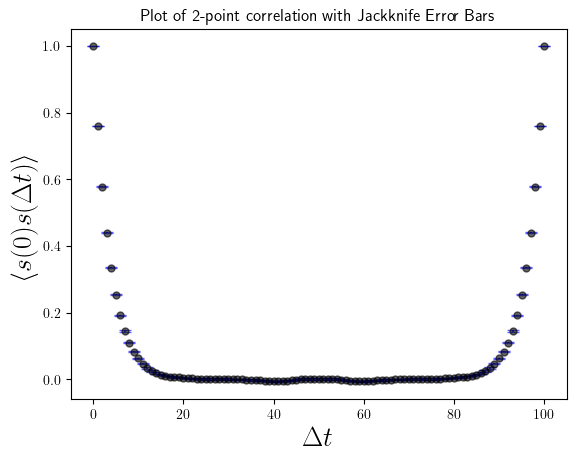

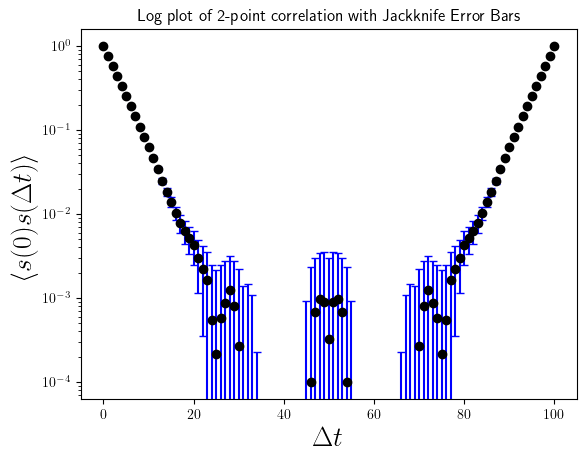

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{physics}"

# Load values and errors
two_pt = []
two_pt_err = []

with open("two_pt.dat", "r") as f_mean, open("two_pt_err.dat", "r") as f_err:
    for line_mean, line_err in zip(f_mean, f_err):
        two_pt.append(float(line_mean))
        two_pt_err.append(float(line_err))

# wrap around to plot at N again
two_pt.append(two_pt[0])
two_pt_err.append(two_pt_err[0])

deltas = list(range(len(two_pt)))

for delta in range(0, len(two_pt), 10):  # Every 10 steps
    print(f"Δt = {delta:2d} | ⟨s(0)s(Δt)⟩ = {two_pt[delta]:.4f} ± {two_pt_err[delta]:.4e}")


plt.errorbar(deltas, two_pt, yerr=np.array(two_pt_err), fmt='o',
             color='black', ecolor='blue', capsize=4, elinewidth=1.5,
             alpha=0.6, markersize=5)
plt.title("Plot of 2-point correlation with Jackknife Error Bars")
plt.xlabel(r"$\Delta t$", fontsize=20)
plt.ylabel(r"$\ev{s(0)s(\Delta t)}$", fontsize=20)
plt.savefig('Plot of 2-point correlation with Jackknife Error Bars.pdf')
plt.show()

plt.errorbar(deltas, two_pt, yerr=np.array(two_pt_err), fmt='o',
            color='black', ecolor='blue', capsize=3)
plt.title("Log plot of 2-point correlation with Jackknife Error Bars")
plt.xlabel(r"$\Delta t$", fontsize=20)
plt.ylabel(r"$\ev{s(0)s(\Delta t)}$", fontsize=20)
plt.yscale('log')
plt.savefig('Log Plot of 2-point correlation with Jackknife Error Bars.pdf')
plt.show()



## Plot of 2 point function WITH binning

In [22]:
import numpy as np
from tqdm import tqdm

# Parameters
N = 256
num_configs = 100000
thermalization = 1_000_000
separation = 1000
K = 0.7

# Flip acceptance probability when all neighbors are aligned
probability_accept = np.exp(-4 * K)

# Update rule (Metropolis-style)
def update(s):
    site = np.random.randint(N)
    
    if s[site] == s[site - 1] and s[site] == s[(site + 1) % N]:
        if np.random.uniform() < probability_accept:
            s_new = s.copy()
            s_new[site] = -s[site]
            return s_new
        else:
            return s
    else:
        s_new = s.copy()
        s_new[site] = -s[site]
        return s_new

# Initial configuration (all +1)
s = [1] * N

# Thermalization phase
for _ in tqdm(range(thermalization), desc="Thermalizing"):
    s = update(s)

# Sampling phase
walk = []

for _ in tqdm(range(num_configs), desc="Sampling configurations"):
    for _ in range(separation):
        s = update(s)
    walk.append(s.copy())

# Save configurations to text file
with open("configurations.dat", "w") as file:
    for config in walk:
        file.write(" ".join(str(spin) for spin in config) + "\n")



Sampling configurations: 100%|█████████| 100000/100000 [02:30<00:00, 665.53it/s]


In [30]:
#Step 4: make error bars using jackknife method by for all separtions

import numpy as np

# Load configurations
walk = []
with open("configurations.dat", "r") as file:
    for line in file:
        walk.append([int(spin) for spin in line.split()])

walk = np.array(walk)
M, N = walk.shape  # M = number of configurations, N = number of spins

# Initialize arrays for mean and jackknife samples
two_pt = np.zeros(N)
two_pt_jk = np.zeros((M, N))

# Compute full average for each delta
for delta in tqdm(range(N), desc="delta"):
    averages = []
    for config in walk:
        avg = np.mean([config[i] * config[(i + delta) % N] for i in range(N)])
        averages.append(avg)
    two_pt[delta] = np.mean(averages)

# Compute jackknife samples
for tau in tqdm(range(M), desc="jk_value"):
    for delta in range(N):
        avg = np.mean([
            walk[tau][i] * walk[tau][(i + delta) % N]
            for i in range(N)
        ])
        # Jackknife resampled value
        two_pt_jk[tau, delta] = (M * two_pt[delta] - avg) / (M - 1)

# Compute error bars
jk_mean = np.mean(two_pt_jk, axis=0)
jk_std = np.std(two_pt_jk,axis=0)
jk_err = np.sqrt((M - 1)) * jk_std

# Save results
with open("two_pt.dat", "w") as f_mean, open("two_pt_err.dat", "w") as f_err:
    for mean_val, err_val in zip(jk_mean, jk_err):
        f_mean.write(f"{mean_val}\n")
        f_err.write(f"{err_val}\n")

jk_value: 100%|█████████████████████████| 100000/100000 [26:22<00:00, 63.19it/s]


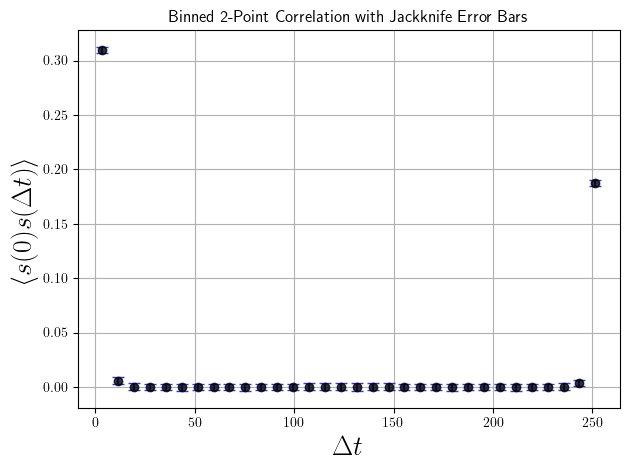

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{physics}"

# Load values and errors
two_pt = []
two_pt_err = []

with open("two_pt.dat", "r") as f_mean, open("two_pt_err.dat", "r") as f_err:
    for line_mean, line_err in zip(f_mean, f_err):
        two_pt.append(float(line_mean))
        two_pt_err.append(float(line_err))

# --- Binning ---
bin_size = 8
num_bins = len(two_pt) // bin_size

binned_means = []
binned_errors = []
binned_deltas = []

for i in range(num_bins):
    start = i * bin_size
    end = start + bin_size
    mean_bin = np.mean(two_pt[start:end])
    # Error propagation for uncorrelated values
    error_bin = np.sqrt(np.sum(np.array(two_pt_err[start:end])**2)) / bin_size

    binned_means.append(mean_bin)
    binned_errors.append(error_bin)
    binned_deltas.append((start + end - 1) / 2)

# Optional: Add final bin for remaining values
if len(two_pt) % bin_size != 0:
    start = num_bins * bin_size
    end = len(two_pt)
    mean_bin = np.mean(two_pt[start:end])
    error_bin = np.sqrt(np.sum(np.array(two_pt_err[start:end])**2)) / (end - start)

    binned_means.append(mean_bin)
    binned_errors.append(error_bin)
    binned_deltas.append((start + end - 1) / 2)

# --- Plot ---

visual_error_scale = 30  # for plotting only
visual_errors = [e * visual_error_scale for e in binned_errors]

plt.errorbar(binned_deltas, binned_means, yerr=visual_errors,
             fmt='o', color='black', ecolor='blue',
             capsize=4, elinewidth=1.5, alpha=0.8)

plt.title("Binned 2-Point Correlation with Jackknife Error Bars")
plt.xlabel(r"$\Delta t$", fontsize=20)
plt.ylabel(r"$\ev{s(0)s(\Delta t)}$", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig('Binned_2pt_Correlation_with_Jackknife.pdf')
plt.show()
